#### Setup

In [ ]:
#This notebok is based on the kaggle discussion that can be found in: https://www.kaggle.com/code/allunia/breast-cancer
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from skimage.transform import resize
import zipfile
from skimage.io import imread
import io
import seaborn as sns
from os import listdir
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
#Configuration environment

import os

os.environ['KAGGLE_USERNAME'] = "nataliacanto"

# username from the json file

os.environ['KAGGLE_KEY'] = "22dfa81f4539576eee33ca26ac952deb"

# key from the json file

In [ ]:
!pwd

/content


In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q '/content/breast-histopathology-images.zip'

Download to drive

#### Drive mount

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse


In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 122523 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Download - do not run

Change path here

In [ ]:
%cd /content/drive/MyDrive/Doutorado/Ciência e análise de dados/projeto/datasets

/content/drive/MyDrive/Doutorado/Ciência e análise de dados/projeto/datasets


Confirm the directory

In [ ]:
!pwd

/content


Download data

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


#### The Data

#### Transforming to a pd dataframe

The number of patients

In [ ]:
base_path = "/content/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)

279

The number of patches

In [ ]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [ ]:
total_images

277524

In [ ]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0      12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...      0
1      12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...      0
2      12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...      0
3      12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...      0
4      12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...      0

In [ ]:
data.shape

(277524, 3)

Here we can see how many patches do we have per class

In [ ]:
data_target = data['target'].value_counts()

In [ ]:
data_target

0    198738
1     78786
Name: target, dtype: int64

#### Visualizing some patches

In [ ]:
data.target = data.target.astype(np.int)

In [ ]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

Examples of patches in which there is cancer

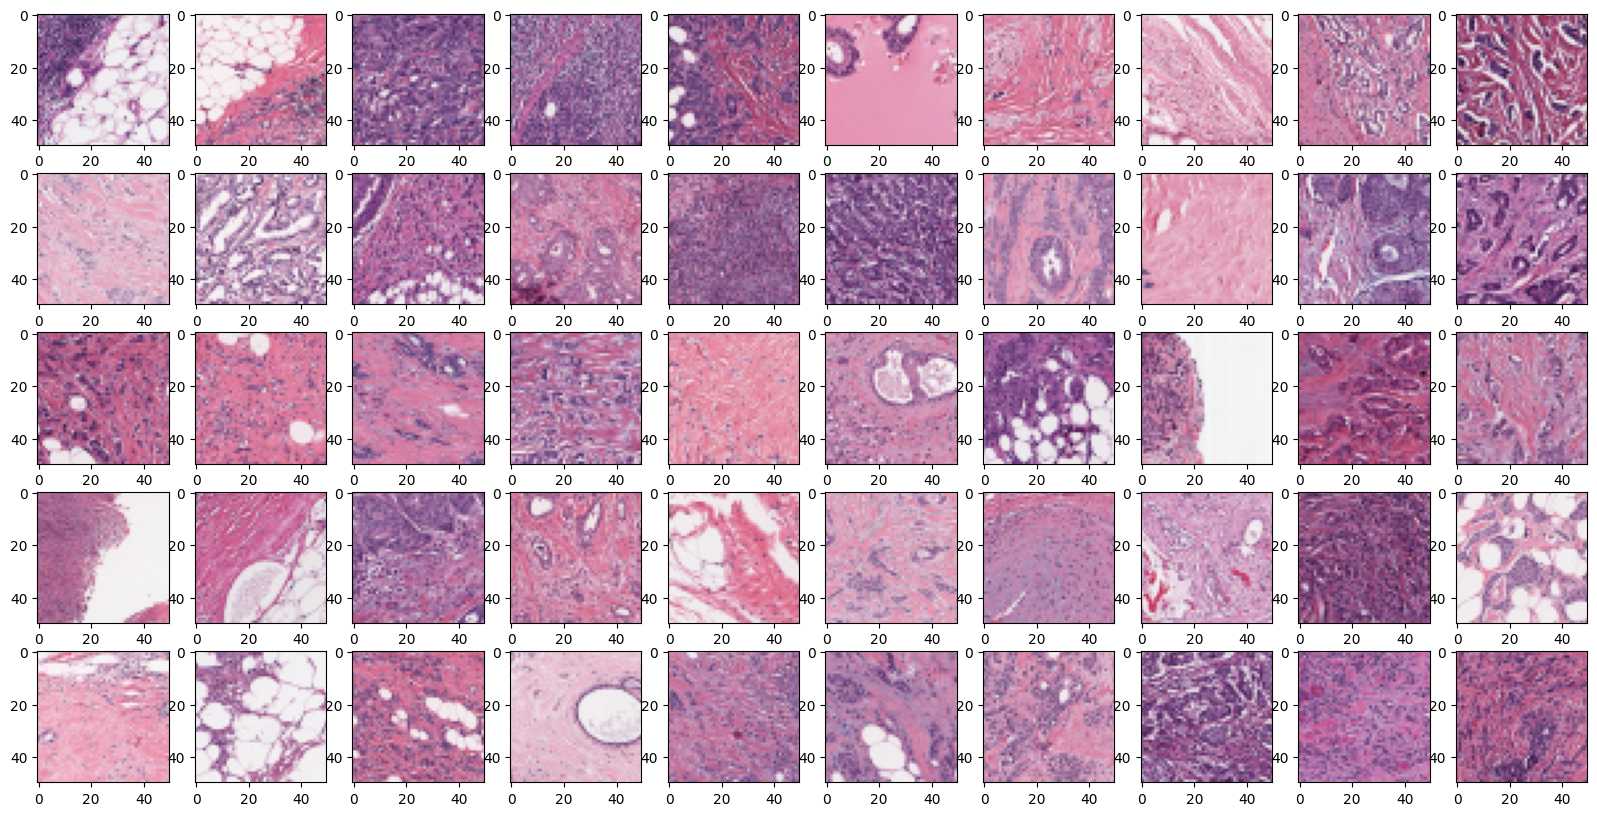

In [ ]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n] # there is IDC
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

Examples of patches in which there is not cancer

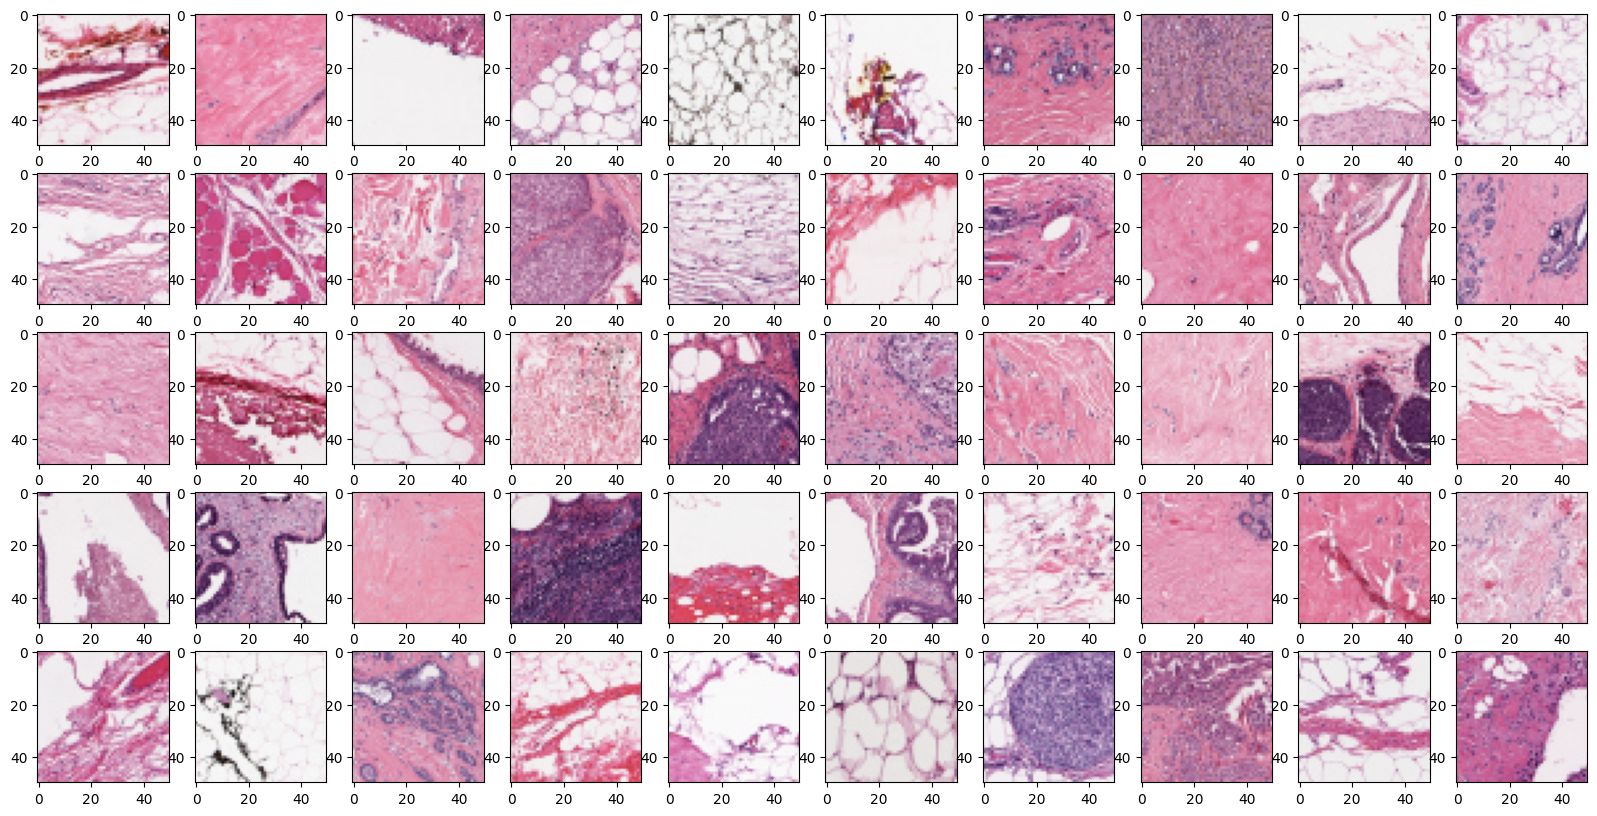

In [ ]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n] # there is not IDC
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)



1.   Some missing values can be seen



#### What can we get from the data

In [ ]:
cancer_p = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
cancer_p = cancer_p.unstack()

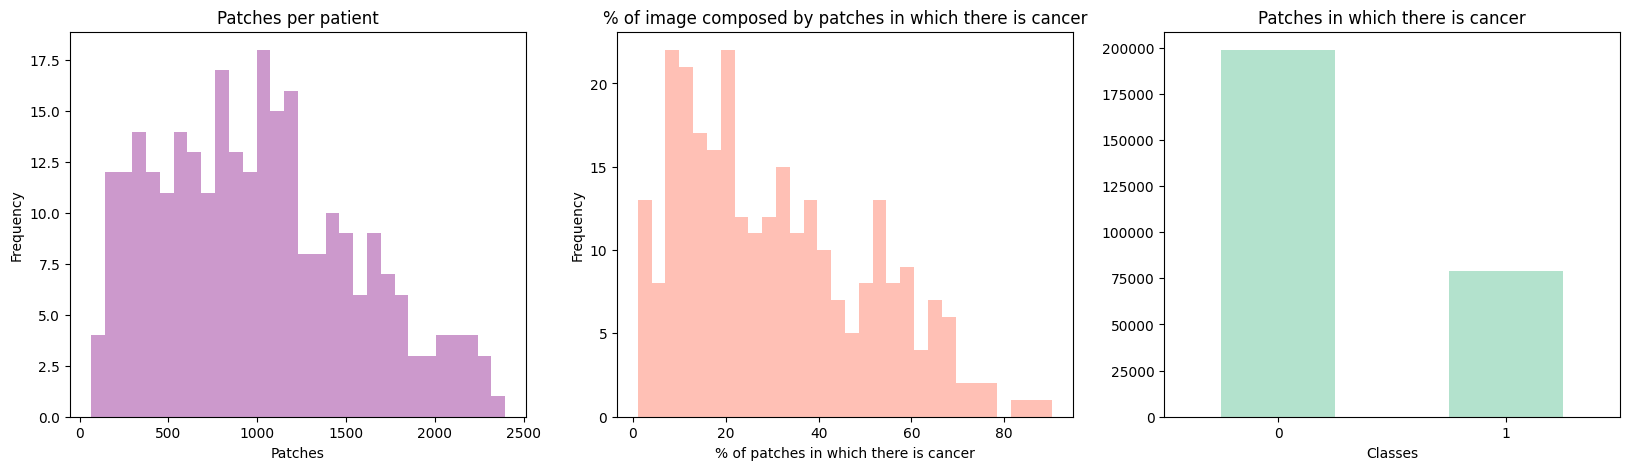

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="purple", kde=False, bins=30)
ax[0].set_xlabel("Patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Patches per patient")
sns.distplot(cancer_p.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("% of image composed by patches in which there is cancer")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches in which there is cancer")
data_target.plot(kind='bar', ax=ax[2],cmap='Pastel2')
ax[2].set_xlabel("Classes")
plt.xticks(rotation = 0)
ax[2].set_title("Patches in which there is cancer")
plt.show()

1.   different number of patches per patient
2.   some patients have data full of cancer, while others don't
3. data augmentation is needed, or working with just a percentage of the 0 class can be an option as well.

#### Visualizing the breast tissue - binary

In [ ]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + patient_id + "/" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [ ]:
example = get_patient_dataframe(data.patient_id.values[0]) #getting the coordinates for each patch, its path to load the image and its target information.
example.head()

x     y  target                                               path
0  1601  1851       0  /content/IDC_regular_ps50_idx5/12900/0/12900_i...
1   901  2101       0  /content/IDC_regular_ps50_idx5/12900/0/12900_i...
2   801  2201       0  /content/IDC_regular_ps50_idx5/12900/0/12900_i...
3  1901   551       0  /content/IDC_regular_ps50_idx5/12900/0/12900_i...
4  2651  1451       0  /content/IDC_regular_ps50_idx5/12900/0/12900_i...

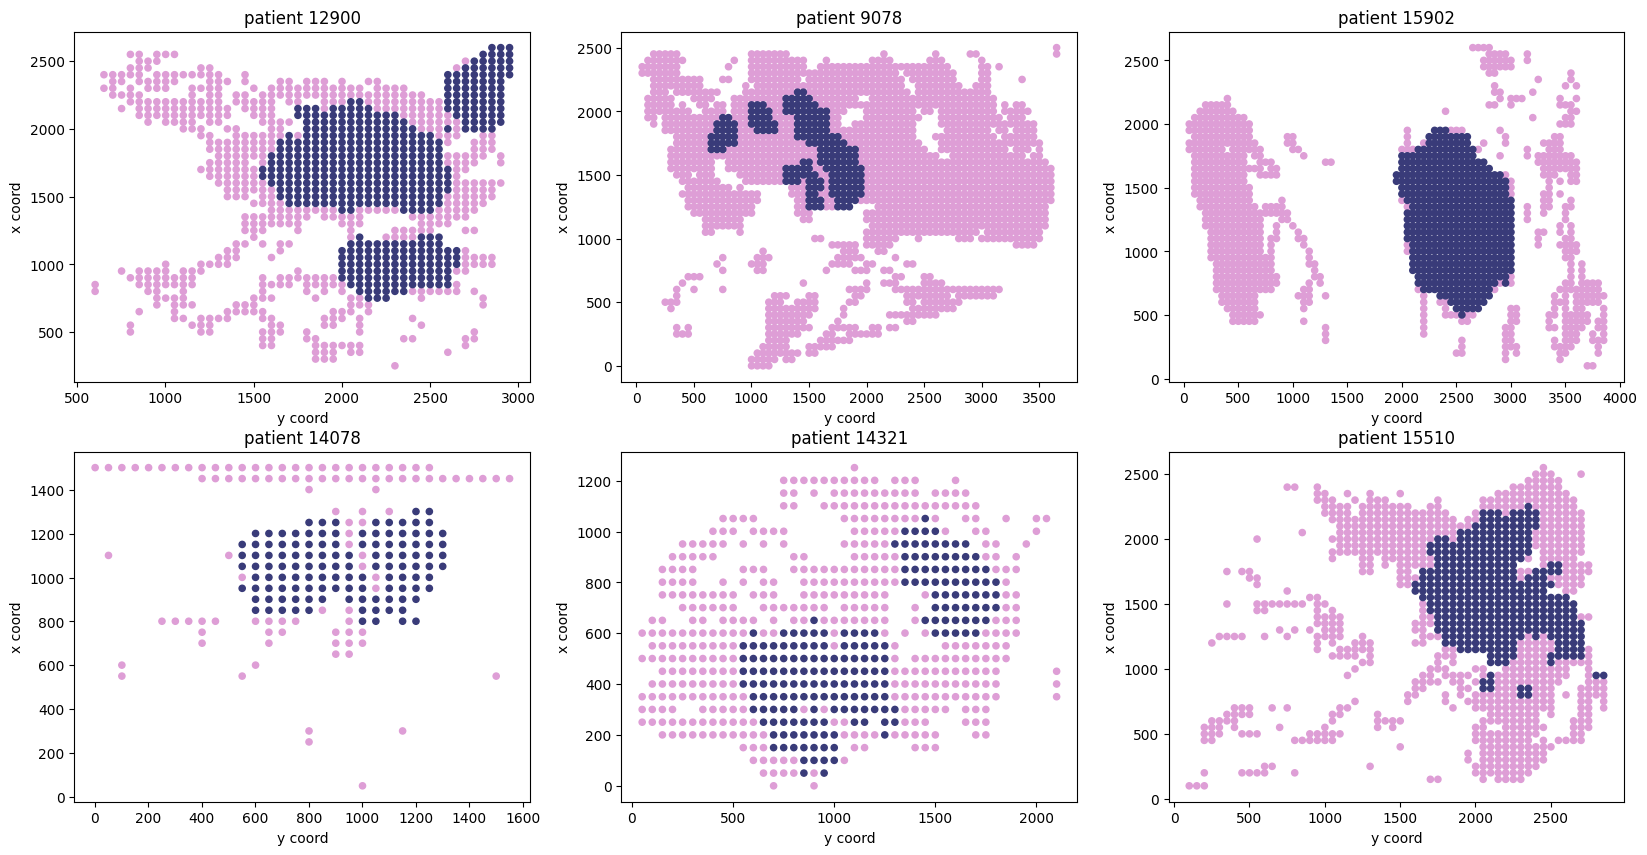

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(20, 10))

patient_ids = data.patient_id.unique()

for n in range(2):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)

        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap='tab20b_r', s=20) #coolwarm,tab20b_r
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

#### Visualising the breast tissue images

In [ ]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            target = example_df.target.values[n]
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    return grid, mask, broken_patches, mask_proba

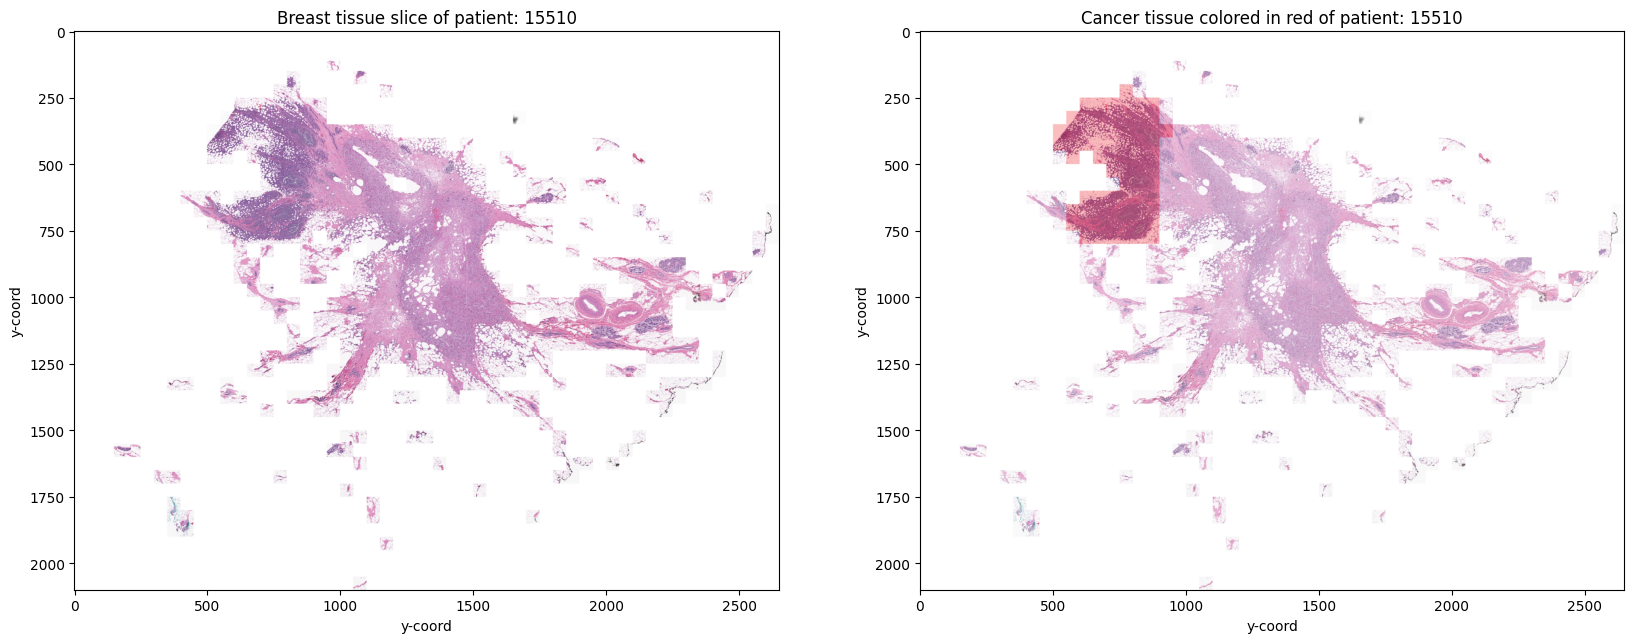

In [ ]:
example = "10253"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,9))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored in red of patient: " + patient_id);

#### Split data into train and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import load_img

In [ ]:
#data.to_csv('image_dataframe.csv', index=False)

In [ ]:
df = pd.read_csv('/content/image_dataframe.csv')

In [ ]:
df.head()

patient_id                                               path  target
0       12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...       0
1       12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...       0
2       12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...       0
3       12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...       0
4       12900  /content/IDC_regular_ps50_idx5/12900/0/12900_i...       0

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: >

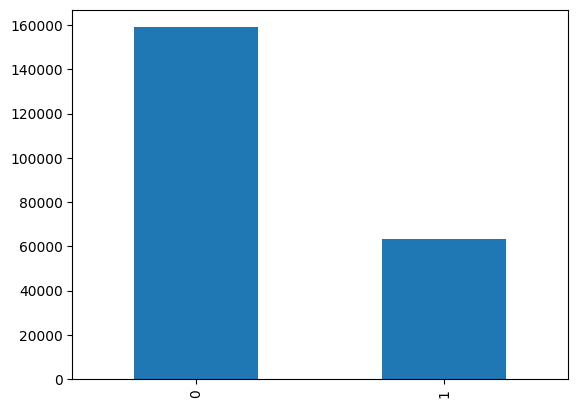

In [ ]:
train_df['target'].value_counts().plot.bar()

<Axes: >

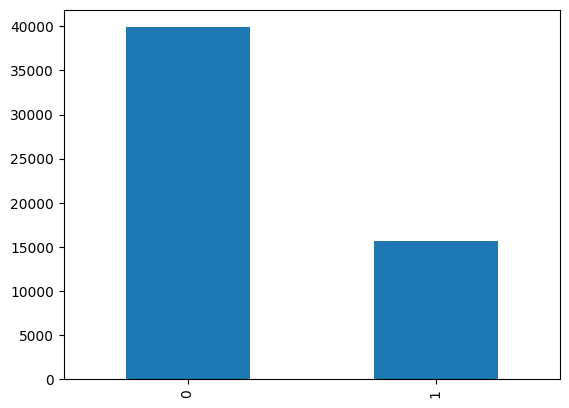

In [ ]:
validate_df['target'].value_counts().plot.bar()

In [ ]:
datagen = ImageDataGenerator(
) 

In [ ]:
# Define the batch size
batch_size = 32

In [ ]:
# Create empty lists to hold the filenames and labels
filenames = []
labels = []

# Walk through each patient's folder
for patient_dir in glob.glob(os.path.join(base_path, '*')):
    for class_dir in glob.glob(os.path.join(patient_dir, '*')):
        class_label = os.path.basename(class_dir)  # Class label is the folder name
        for image_file in glob.glob(os.path.join(class_dir, '*.png')):
            filenames.append(image_file)
            labels.append(class_label)

In [ ]:
# Create a dataframe
df1 = pd.DataFrame({
    'filename': filenames,
    'target': labels
})

In [ ]:
train_df, valid_df = train_test_split(df1, test_size=0.2, random_state=42, stratify=df['target'])

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Define the batch size
batch_size = 32

In [ ]:
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='target',
    target_size=(40, 40),  
    class_mode='binary',  # for binary classification
    batch_size=batch_size,
    shuffle=True)

Found 222019 validated image filenames belonging to 2 classes.


In [ ]:
valid_gen = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='target',
    target_size=(40, 40),  
    class_mode='binary',  
    batch_size=batch_size,
    shuffle=False)

Found 55505 validated image filenames belonging to 2 classes.


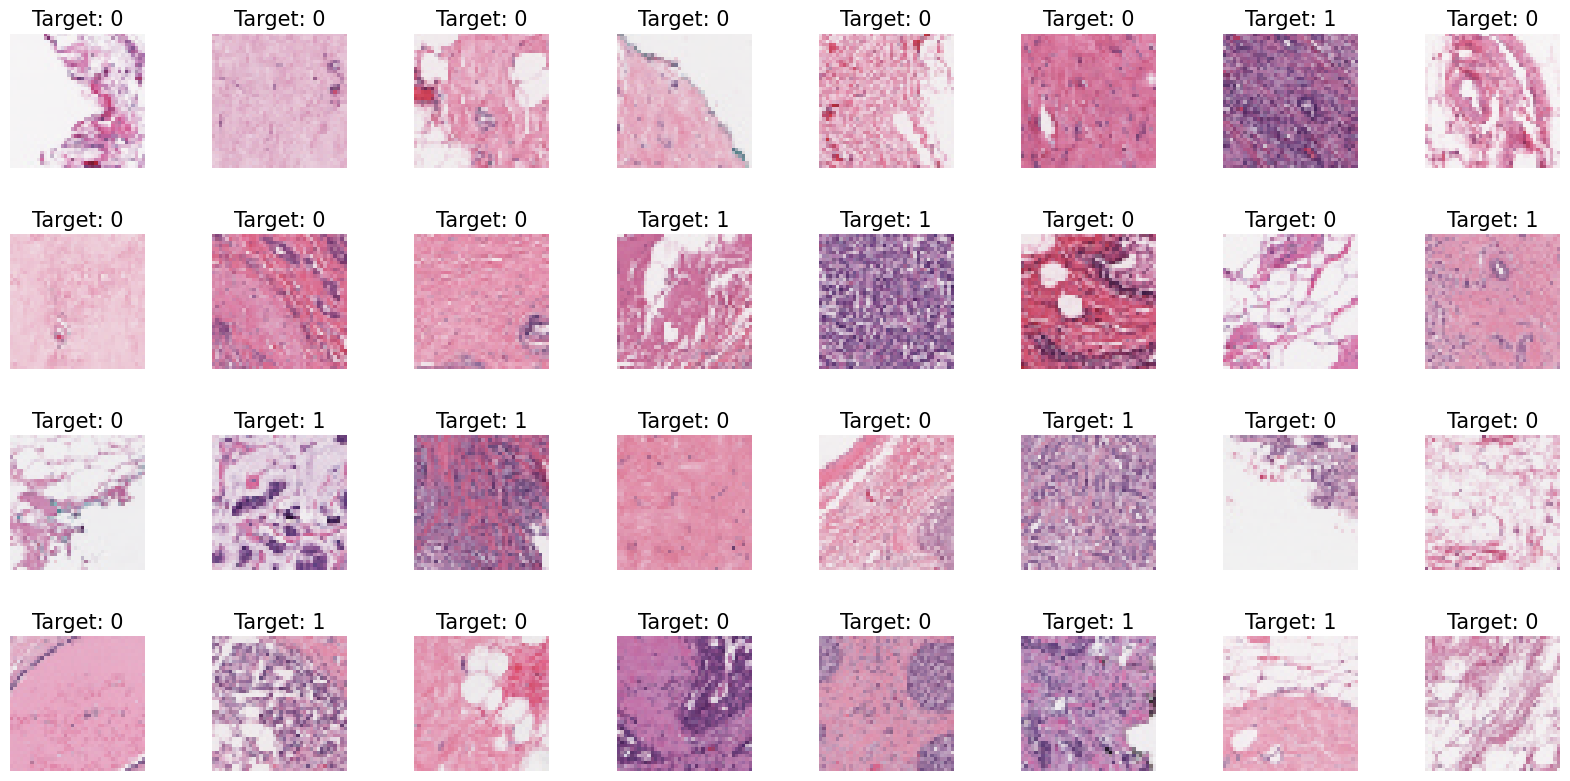

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of patches and labels
images, labels = next(train_gen)
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.ravel()

for i in np.arange(0, 32): 
    axes[i].imshow(images[i])
    axes[i].set_title(f'Target: {labels[i]}', fontsize=15)
    axes[i].axis('off')
    axes[i].set_title(f'Target: {int(labels[i])}', fontsize=15)

plt.subplots_adjust(wspace=0.5)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weights = dict(zip(np.unique(train_gen.classes), compute_class_weight(
                        class_weight = 'balanced',
                        classes = np.unique(train_gen.classes), 
                        y = train_gen.classes)))
class_weights

{0: 0.69808514652245, 1: 1.7620835251353195}